# Tri-geometric analysis of trial-based neuronal activity

This notebook is intended as a demo for applying the tri-geometry analysis presented in the paper "Hierarchical Coupled-Geometry Analysis for Neuronal Structure and Activity Pattern Discovery". 
Our dataset, as described in the paper, consists of neuronal measurements from the primary motor cortex region (M1), taken from an awake behaving animal in a single day of experimental training sessions. The data includes 59 trials of length 119 time-frames (~12 seconds).
In this notebook we will analyze the dataset in three dimensions (neurons, time frames, trials) and reproduce the figures given in the paper.

Unfortunately, our dataset is propriety and cannot be distributed, but this notebook can be adapted to any trial-based data or even general 3D datasets. 

In [1]:
%matplotlib inline

import random
import scipy.io

from imports import *
import matplotlib.pyplot as plt
import questionnaire
 
from pylab import cm

Load data and convert from 2D matlab matrix to 3D array

In [2]:
temp = scipy.io.loadmat("jstsp_data.mat")
# neuronal measurement of consecutive trials
data = temp["matrix"]
# labeled events for every trial
event_names = temp["points_dat_score_titles"]
event_names = [str(''.join(letter)) for letter_array in event_names[0]
                         for letter in letter_array]
events = temp["points_dat_scores"]
# id for each neuron
neurons_titles = temp["sensors_dat_titles"]
neurons_titles = [str(''.join(letter)) for letter_array in neurons_titles[0]
                           for letter in letter_array]
del temp

n_neurons, ncols = data.shape
trial_length = 119
tone = 39
n_trials = int(ncols / trial_length)

# convert to 3D
data3d = np.reshape(data, (n_neurons, trial_length, -1),order='F')
n_events,_ = events.shape

In [3]:
# for visualization purposes
neuron_leafcolors = np.arange(0, n_neurons)
time_leafcolors = np.arange(0, trial_length)
trial_leafcolors = np.arange(0, n_trials)
tone_leafcolors = np.zeros((trial_length))
tone_leafcolors[tone:] = 1

Figure 4: Binary event labels for two trials. (left) Successful trial in which the subject grabs and eats the food pellet. (right) Failure in which the subject
makes several failed attempts to grab the food.

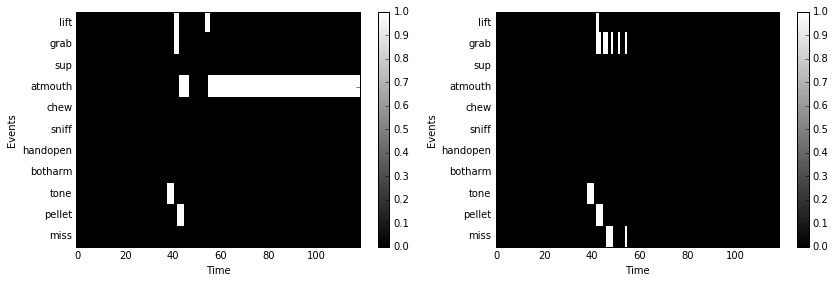

In [4]:
fig = plt.figure(figsize = (12,4))
fig.add_subplot(121)
bwplot(events[:,10*trial_length+np.arange(0,trial_length)])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Events')
plt.yticks(range(n_events),event_names)

fig.add_subplot(122)
bwplot(events[:,11*trial_length+np.arange(0,trial_length)])
plt.colorbar()
plt.xlabel('Time')
plt.ylabel('Events')
plt.yticks(range(n_events),event_names)
plt.tight_layout()
plt.show()

View neuronal measurements of the two labeled trials

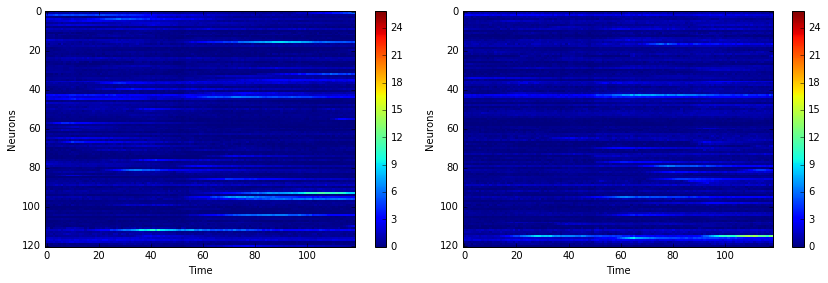

In [5]:
fig = plt.figure(figsize = (12,4))
fig.add_subplot(121)
plt.imshow(data3d[:,:,10], vmin=abs(data3d).min(), vmax=abs(data3d).max(), interpolation='nearest', aspect='auto')
plt.colorbar()
plt.ylabel('Neurons')
plt.xlabel('Time')

fig.add_subplot(122)
plt.imshow(data3d[:,:,11], vmin=abs(data3d).min(), vmax=abs(data3d).max(), interpolation='nearest', aspect='auto')
plt.colorbar()
plt.ylabel('Neurons')
plt.xlabel('Time')

plt.tight_layout()
plt.show()

Initialize questionnaire parameters: we use cosine similarity for inital affinity matrices, flexible partition trees and the bi-tree metric proposed in the paper. For the weights used in the bi-tree metric, we choose $\beta_r = 1, \beta_t = 1, \beta_T = 0$.

In [6]:
init_aff = questionnaire.INIT_AFF_COS_SIM
row_tree_type = questionnaire.TREE_TYPE_FLEXIBLE
col_tree_type = questionnaire.TREE_TYPE_FLEXIBLE
chan_tree_type = questionnaire.TREE_TYPE_FLEXIBLE

row_aff_type = questionnaire.DUAL_EMD
col_aff_type = questionnaire.DUAL_EMD
chan_aff_type = questionnaire.DUAL_EMD
kwargs = {}
kwargs["n_iters"] = int(1)
kwargs["row_beta"] = 1.0
kwargs["col_beta"] = 1.0
kwargs["chan_beta"] = 0.0
kwargs["row_alpha"] = 0.0
kwargs["col_alpha"] = 0.0
kwargs["chan_alpha"] = 0.0
kwargs["row_tree_constant"] = 1

init_tree = [row_tree_type,col_tree_type,chan_tree_type]
params = questionnaire.PyQuest3DParams(init_aff,init_tree,
             row_aff_type,col_aff_type,chan_aff_type,**kwargs)

Run tri-geometry analysis

In [7]:
qrun = questionnaire.pyquest3d(data3d,params)

Initialization of trial dimension for visualization and comparison purposes (neuron and time dimensions were initialized in pyquest3d run)

In [8]:
data_Z =  np.reshape(data3d, (n_neurons*trial_length, n_trials),order='F') 
init_trial_aff = affinity.mutual_cosine_similarity(
                    data_Z,False,0,threshold=params.init_aff_threshold)
init_trial_tree = flex_tree_build.flex_tree_diffusion(init_trial_aff,
                    params.chan_tree_constant)
init_trial_vecs,init_trial_vals = markov.markov_eigs(init_trial_aff,12)

Calculate embedding of time and trial dimensions

In [9]:
n_eigs = 12
trial_vecs,trial_vals = markov.markov_eigs(qrun.chan_aff,n_eigs)
time_vecs,time_vals = markov.markov_eigs(qrun.col_aff,n_eigs)

Plotting initial neurons and time trees. 
Leaves are colored by index in the 3D data matrix. Note that the clustering of the neurons is not smooth in terms of the index as the indices are arbitrary and do not indicate similarity. This is opposed to the time tree where the clustering is smooth as is the time dimension itself.

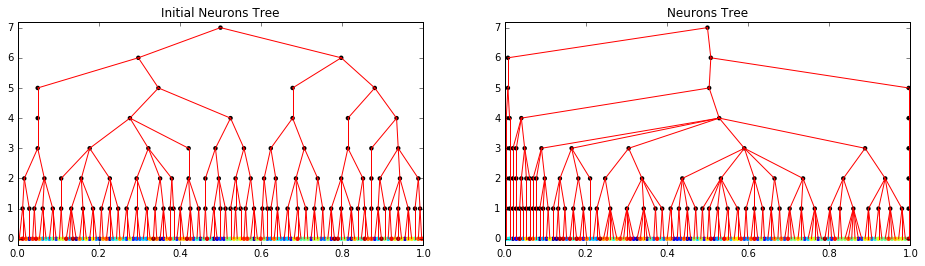

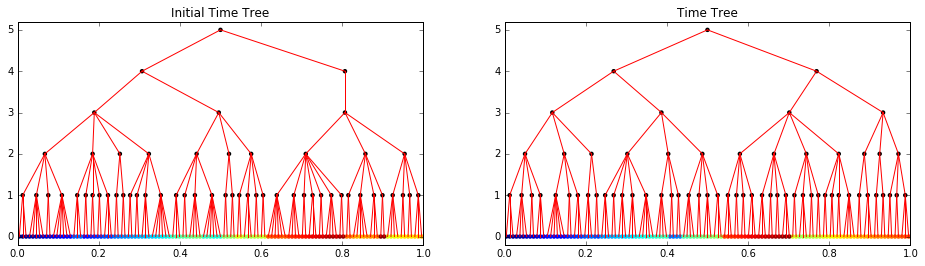

In [10]:
fig = plt.figure(figsize = (16,4))
fig.add_subplot(121)
plot_tree(qrun.row_trees[0], title="Initial Neurons Tree", leafcolors=neuron_leafcolors, useplt=True)
fig.add_subplot(122)
plot_tree(qrun.row_trees[-1], title="Neurons Tree", leafcolors=neuron_leafcolors, useplt=True)
plt.show()

fig = plt.figure(figsize = (16,4))
fig.add_subplot(121)
plot_tree(qrun.col_trees[0], title="Initial Time Tree", leafcolors=time_leafcolors, useplt=True)
fig.add_subplot(122)
plot_tree(qrun.col_trees[-1], title="Time Tree", leafcolors=time_leafcolors, useplt=True)
plt.show()

Figure 5(a) and (b): Embedding of time frames. (a-b) 3-dimensional embedding of all the 2D time frame slices, constructed by our tri-geometry analysis, where each time sample (t ∈ {1,..., 119}) is a 3D point. In (a) the points are colored by the time frame index, and in (b) they are colored accordingto pre-tone frames (blue) and post-tone frames (red). The tone, played at sample t=42 (marked by an arrow), is distinctively recovered from the data. 

Figure 5 (c): First 11 eigenvectors of time embedding. Each column is an eigenvector $\psi_{t,\ell}\in\mathbb{R}^{119} \; \ell \in \{1,...,11\}$.
In general, the eigenvectors take the form of harmonic functions at different scales. 
Time $t=42$ (the tone) is apparent (marked by the box). 
Some eigenvectors correspond to harmonic functions over the entire trial (e.g., $\psi_{t,1}$), while some are localized in the pre-tone region (e.g., $\psi_{t,9}$), and some in the post-tone region (e.g., $\psi_{t,11}$).

Thus, in a completely data-driven manner, a Fourier-like (harmonic) basis is attained. However, in contrast to the “generic” Fourier-basis, which is fixed, the obtained basis is data adaptive and captures and characterized true hidden phenomena related to external stimuli (the tone) and to different patterns of behavior (before and after the tone).

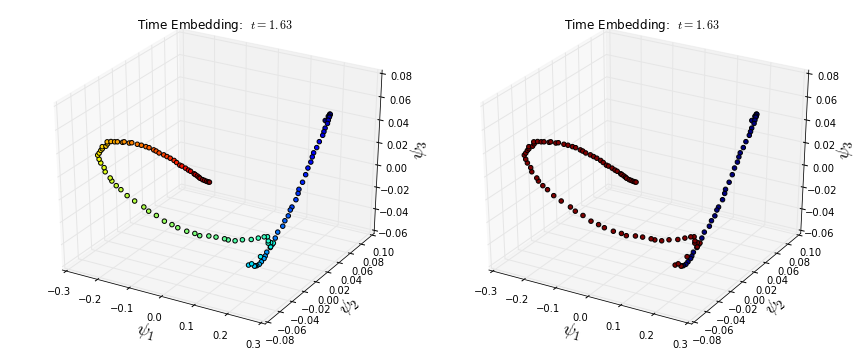

In [11]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121,projection="3d")
plot_embedding(time_vecs,time_vals,ax=ax1,
               title="Time Embedding: ",
               nodecolors=time_leafcolors,
               noNorm=True)
ax1.set_xlabel('$\psi_1$', fontsize=18)
ax1.set_ylabel("$\psi_2$", fontsize=18)
ax1.set_zlabel("$\psi_3$", fontsize=18)

ax2 = fig.add_subplot(122,projection="3d")
plot_embedding(time_vecs,time_vals,ax=ax2,
               title="Time Embedding: ",
               nodecolors=tone_leafcolors,
                       noNorm=True)
ax2.set_xlabel("$\psi_1$", fontsize=18)
ax2.set_ylabel("$\psi_2$", fontsize=18)
ax2.set_zlabel("$\psi_3$", fontsize=18)

plt.tight_layout()
plt.show()

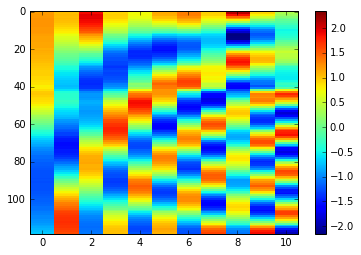

In [12]:
fig = plt.figure(figsize = (6,4))
plt.imshow(time_vecs[:,1:], interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

The data is composed of 59 consecutive trials, where the first 19 trials are considered “control” followed by 40 trials in which the activity of the somatosensory region was silenced by injection of CNO, thus activating DREADDS. Below, the points in the embedding and the trees are colored by the trial index where blue corresponds to control trials (1-19), greenorange trials corresponds to the first silencing trials (19-44), and red corresponds to last silencing trials (45-59).

Figure 6: The 3D embedding of the 2D trial slices (Fig. 1(left)) of all the trials T ∈ {1,..., 59}. Each trial slice is represented by a single 3D point, colored by the trial index (here as well, the trial index was not taken into account in the analysis). (a) Initial trial embedding based on cosine affinity. (b) Trial embedding derived from bi-tree multiscale metric. Trials are clustered in three main groups, where red and blue clusters are closer together.

Our trigeometry analysis yields an embedding in which the blue and red points, corresponding to the first and last trials, respectively, are grouped together. This clearly indicates the temporal effect of silencing the somatosensory cortex on the activity of motor cortex.  This result leads us to hypothesize that our silencing manipulation has a lag, and also that it expires over the duration of the experiment.

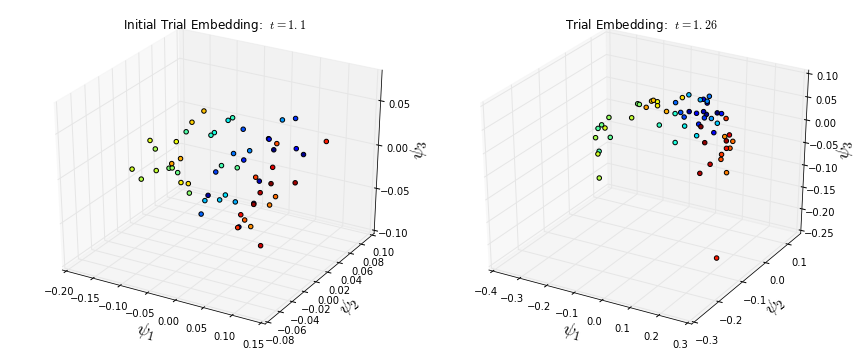

In [13]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121,projection="3d")
plot_embedding(init_trial_vecs,init_trial_vals,ax=ax1,
               title="Initial Trial Embedding: ",
               nodecolors=trial_leafcolors,
               noNorm=True)
ax1.set_xlabel("$\psi_1$", fontsize=18)
ax1.set_ylabel("$\psi_2$", fontsize=18)
ax1.set_zlabel("$\psi_3$", fontsize=18)
ax2 = fig.add_subplot(122,projection="3d")
plot_embedding(trial_vecs,trial_vals,
               title="Trial Embedding: ",ax=ax2,
               nodecolors=trial_leafcolors,
               noNorm=True)
ax2.set_xlabel("$\psi_1$", fontsize=18)
ax2.set_ylabel("$\psi_2$", fontsize=18)
ax2.set_zlabel("$\psi_3$", fontsize=18)

plt.tight_layout()
plt.show()

Figure 7: Flexible tree of trials (T ∈ {1,..., 59}). The leaves are colored by trial index. (a) Tree corresponding to initial trial embedding in Fig. 6(a). (b) Tree corresponding to bi-tree multiscale metric embedding in Fig. 6(b). This tree better captures the nature of the trials, separating the pathological dysfunction caused by the silencing from the normal trials.

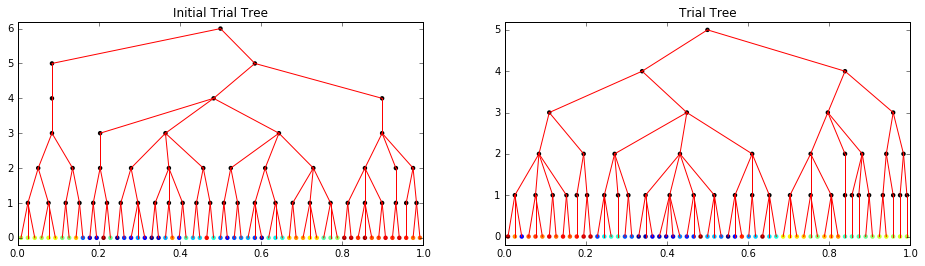

In [14]:
fig = plt.figure(figsize = (16,4))
fig.add_subplot(121)
plot_tree(init_trial_tree, title="Initial Trial Tree", leafcolors=trial_leafcolors, useplt=True)
fig.add_subplot(122)
plot_tree(qrun.chan_trees[-1], title="Trial Tree", leafcolors=trial_leafcolors, useplt=True)
plt.show()